## Project - Part II


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gaussian_process import (
    optimize_kernel_params,
    plot_grid_search_results,
    predict_conditional_mean_and_var,
)
from sklearn.gaussian_process.kernels import RBF

### Data Loading


In [2]:
# Time steps in the simulation
n_steps = 100

# Speed flow: 3D array with shape (Time, X coordinates, Y coordinates, 2)
speed_flow = []

# Load the X and Y data for each time step
for i in range(n_steps):

    # Load the data for X and Y
    # The data is given in a matrix with data for each position in the grid
    Vx = pd.read_csv(f'./OceanFlow/{i+1}u.csv', header=None).values
    Vy = pd.read_csv(f'./OceanFlow/{i+1}v.csv', header=None).values

    # Construct the total velocity by concatenating the X and Y components as
    # columns in a single array
    V = np.stack([Vx, Vy], axis=2)

    # Add the current time step velocity to the speed_flow array
    speed_flow.append(V)

# Convert the speed_flow list to a numpy array
Vt = np.array(speed_flow)
print("Data Shape:", Vt.shape)
print("- Timesteps:", Vt.shape[0])
print("- Y coordinates:", Vt.shape[1])
print("- X coordinates:", Vt.shape[2])
print("- Velocity components:", Vt.shape[3])

# Get the X and Y velocities
Vx = Vt[:, :, :, 0]
Vy = Vt[:, :, :, 1]

# Load the mask data
mask = pd.read_csv('./OceanFlow/mask.csv', header=None).values

# The mask is flipped in the Y axis, so we flip it back
mask = np.flip(mask, axis=0)


Data Shape: (100, 504, 555, 2)
- Timesteps: 100
- Y coordinates: 504
- X coordinates: 555
- Velocity components: 2


### Part II

#### Problem 4.a (10 points)

Take into consideration that now measurements are considered to have 3 days between them, instead of the 3 hours used in the previous part.


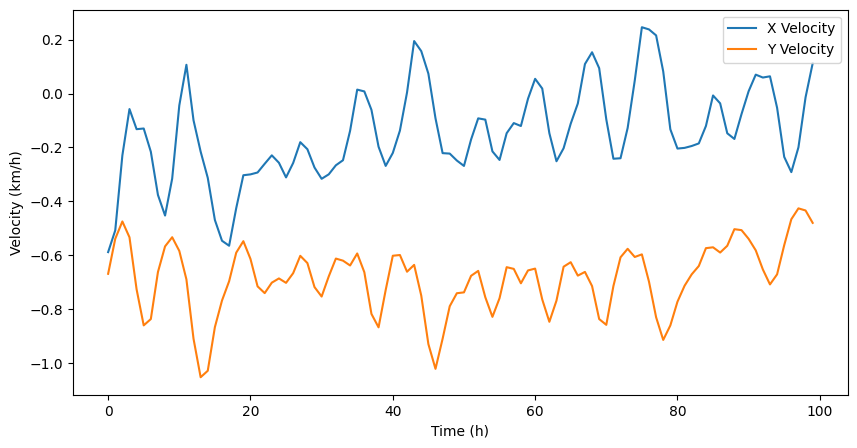

In [3]:
# Select a specific location to get the velocity data
x = 400
y = 200

# Get the velocity data for the selected location (Vl = Location Velocity)
V_loc = Vt[:, y, x, :]

# Get the X and Y velocity components
Vx_loc = V_loc[:, 0]
Vy_loc = V_loc[:, 1]

# ==================== PLOT ==================== #

# Plot the X and Y velocity components
plt.figure(figsize=(10, 5))
plt.plot(Vx_loc, label='X Velocity')
plt.plot(Vy_loc, label='Y Velocity')
plt.legend()
plt.xlabel('Time (h)')
plt.ylabel('Velocity (km/h)')
plt.show()

100%|██████████| 100/100 [00:06<00:00, 14.60it/s]



Vx - Optimal 'l':  1.188888888888889
Vx - Optimal 'sigma':  1.0
Vy - Optimal 'l':  1.188888888888889
Vy - Optimal 'sigma':  1.0


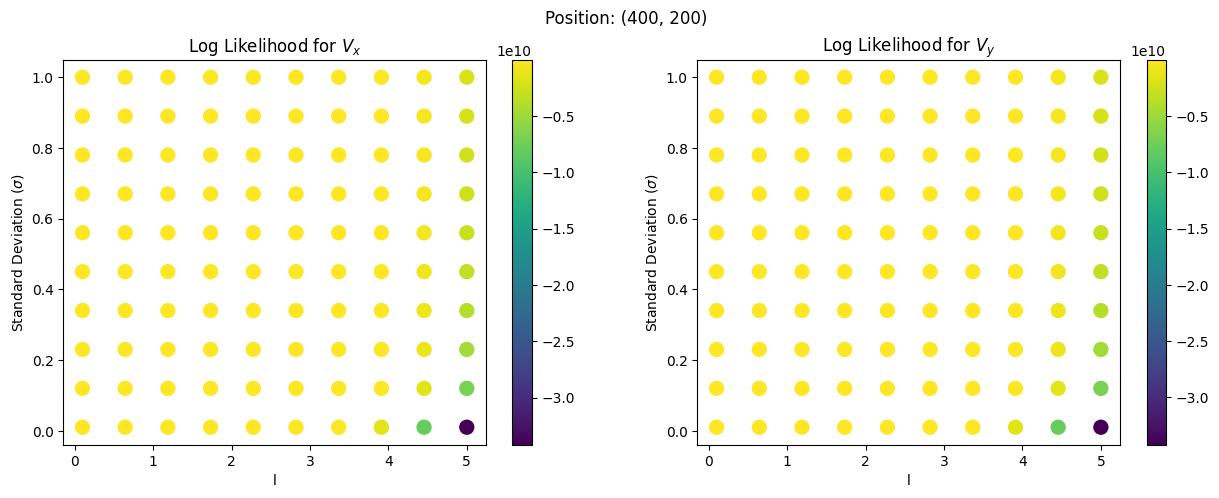

In [4]:
# ================ OPTIMIZATION ================ #

# Create a range of values for "l" and "sigma"
l_range = np.linspace(0.1, 5, 10)
std_range = np.linspace(0.01, 1, 10)

# Folds to use for cross validation
num_folds = 15

# Optimize the kernel parameters for the X component
l_x, std_x, x_results_df = optimize_kernel_params(
    data=Vx_loc,
    l_range=l_range,
    std_range=std_range,
    num_folds=num_folds
)

# Optimize the kernel parameters for the Y component
l_y, std_y, y_results_df = optimize_kernel_params(
    data=Vy_loc,
    l_range=l_range,
    std_range=std_range,
    num_folds=num_folds
)

# Label the parameters for each axis as "optimal"
optimal_l_x = l_x
optimal_std_x = std_x
optimal_l_y = l_y
optimal_std_y = std_y

# =================== RESULTS ================== #

print()
print("Vx - Optimal 'l': ", l_x)
print("Vx - Optimal 'sigma': ", std_x)
print("Vy - Optimal 'l': ", l_y)
print("Vy - Optimal 'sigma': ", std_y)

# ==================== PLOT ==================== #

# Plot the results of the grid search
plot_grid_search_results(
    x_results_df=x_results_df,
    y_results_df=y_results_df,
    position=np.array([x, y])
)

#### Problem 4.b (5 points)


100%|██████████| 100/100 [00:06<00:00, 14.42it/s]


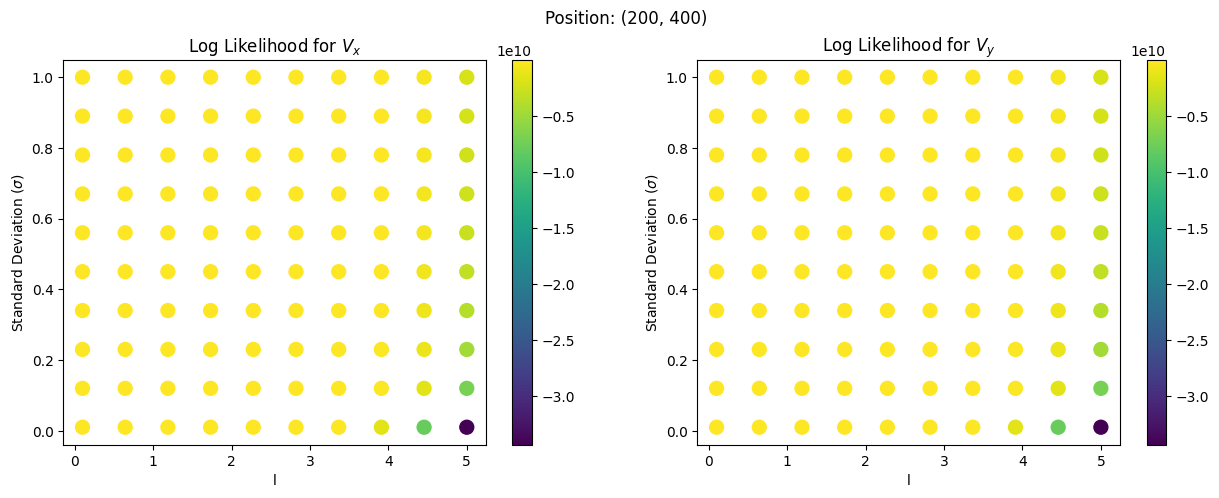

100%|██████████| 100/100 [00:06<00:00, 14.55it/s]


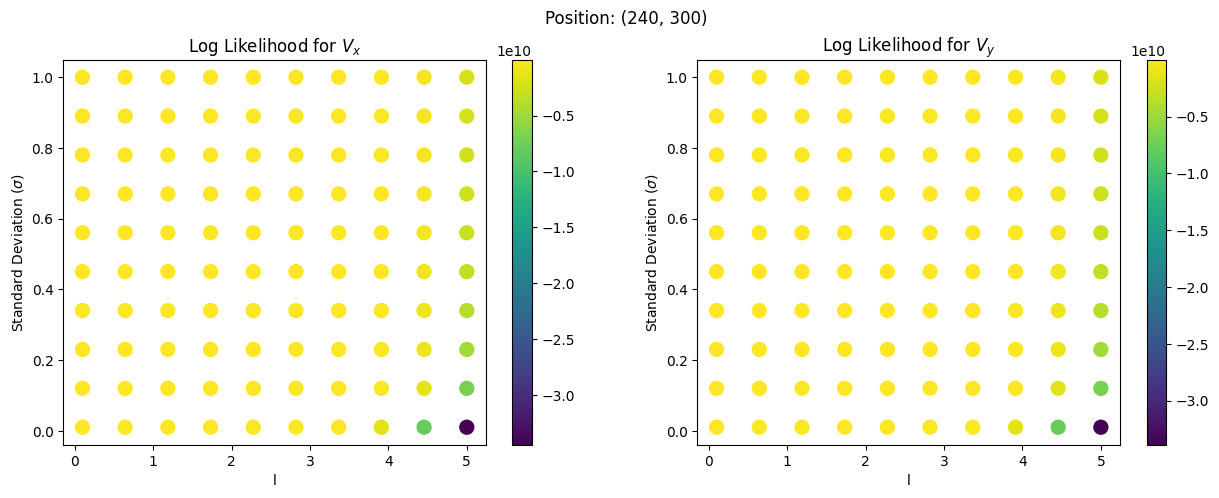

100%|██████████| 100/100 [00:06<00:00, 14.84it/s]


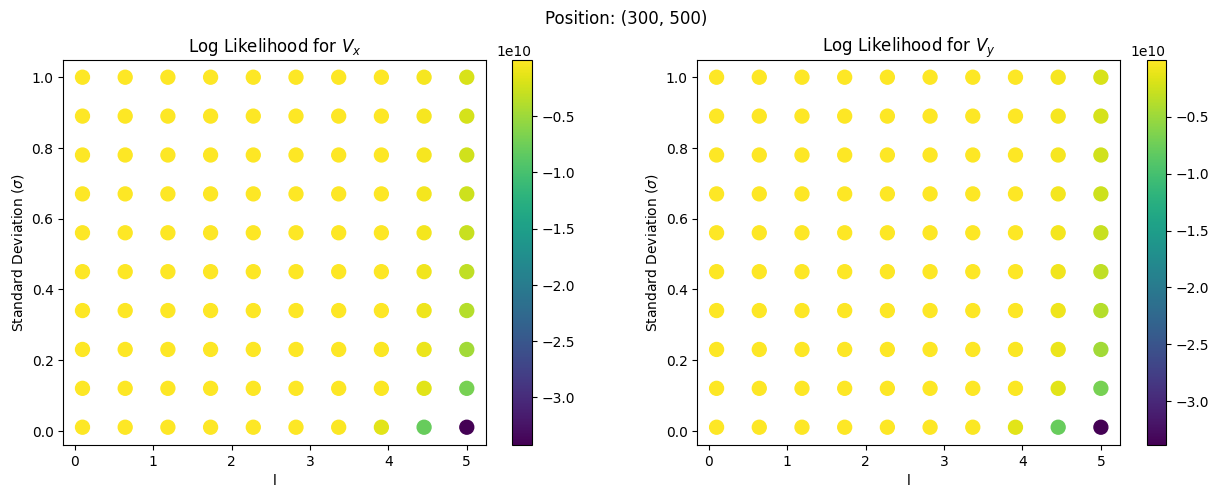

In [5]:
# Different positions to test for the prediction
positions = np.array([
    [200, 400],
    [240, 300],
    [300, 500],
])

# Create a range of values for "l" and "sigma"
l_range = np.linspace(0.1, 5, 10)
std_range = np.linspace(0.01, 1, 10)

for position in positions:

    # Get the velocity data for the selected location
    x = position[0]
    y = position[1]
    V_loc = Vt[:, y, x, :]

    # Get the X and Y velocity components
    Vx_loc = V_loc[:, 0]
    Vy_loc = V_loc[:, 1]

    # Number of folds to use for cross validation
    num_folds = 15

    # Optimize the kernel parameters for the X component
    l_x, std_x, x_results_df = optimize_kernel_params(
        data=Vx_loc,
        l_range=l_range,
        std_range=std_range,
        num_folds=num_folds
    )

    # Optimize the kernel parameters for the Y component
    l_y, std_y, y_results_df = optimize_kernel_params(
        data=Vy_loc,
        l_range=l_range,
        std_range=std_range,
        num_folds=num_folds
    )

    # Plot the results of the grid search
    plot_grid_search_results(
        x_results_df=x_results_df,
        y_results_df=y_results_df,
        position=position
    )


#### Problem 4.c (5 points)


100%|██████████| 100/100 [00:04<00:00, 20.29it/s]


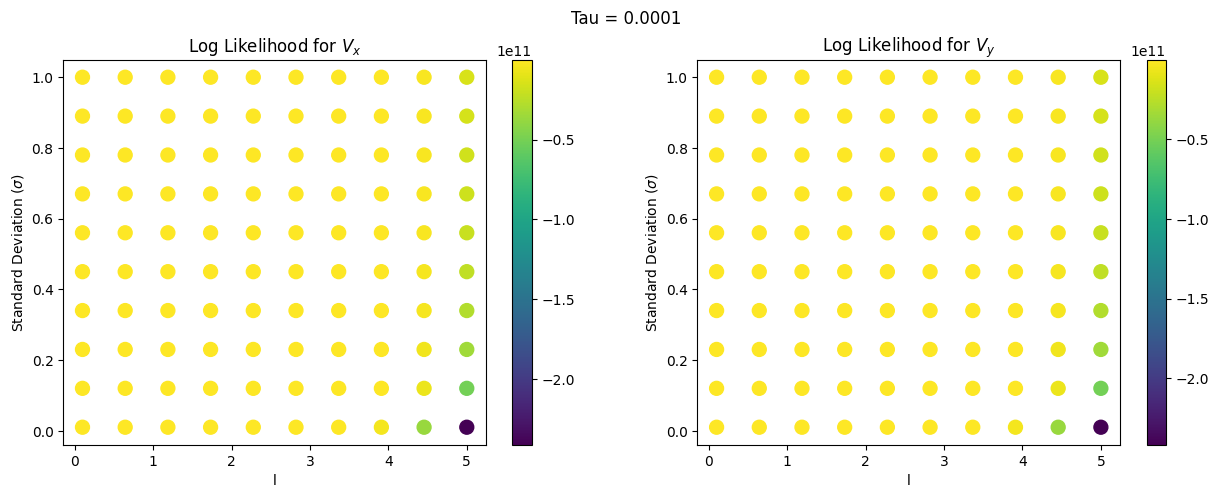

100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


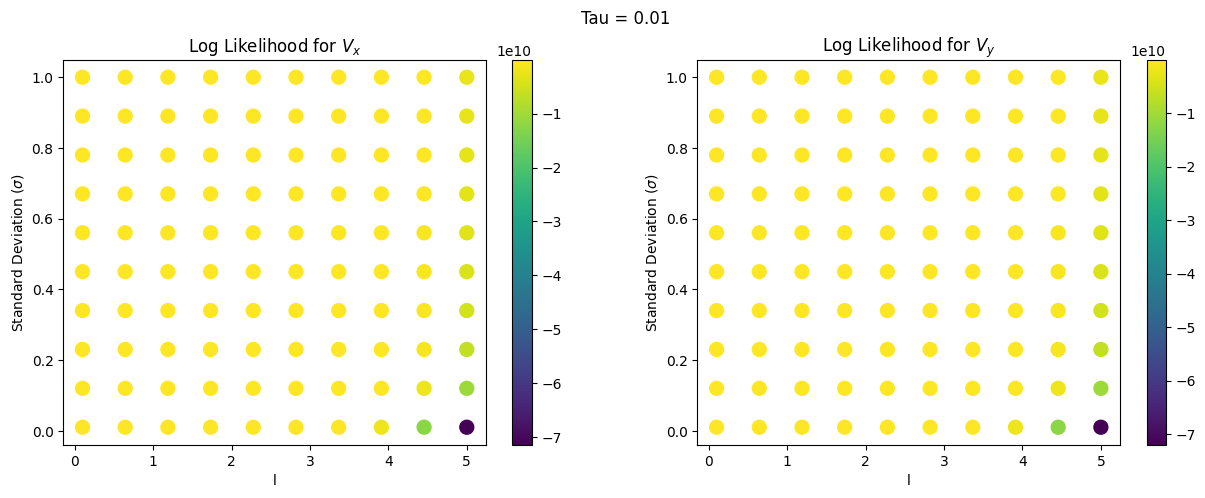

100%|██████████| 100/100 [00:04<00:00, 24.15it/s]


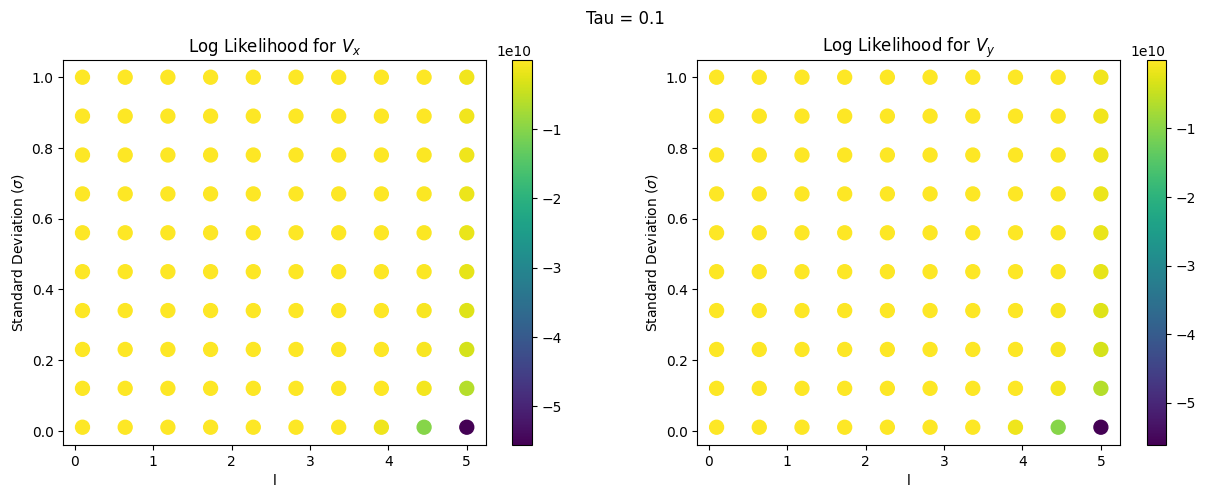

100%|██████████| 100/100 [00:04<00:00, 24.18it/s]


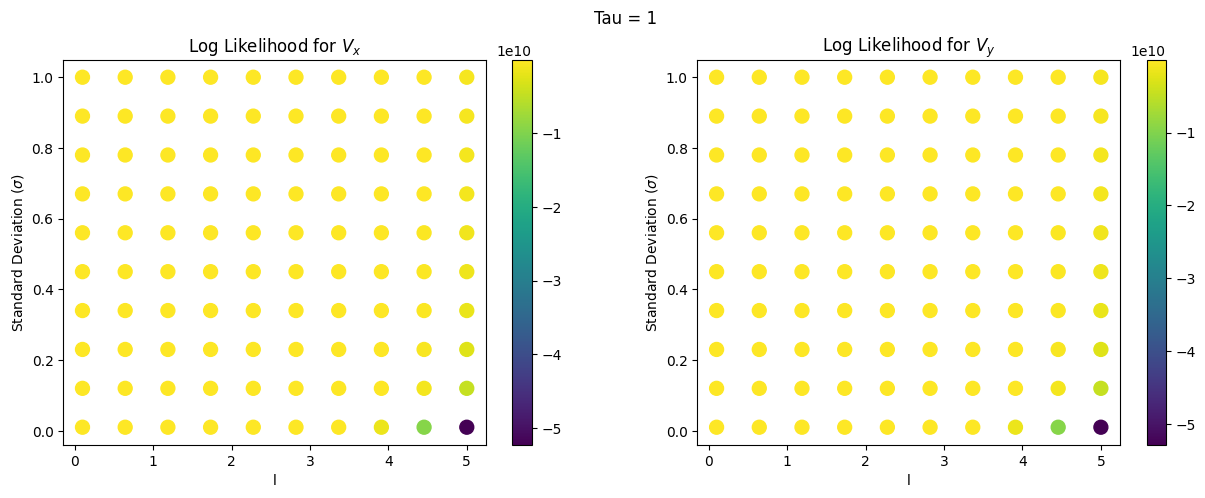

In [6]:
# Values of Tau to test
tau_values = [0.0001, 0.01, 0.1, 1]

# Create a range of values for "l" and "sigma"
l_range = np.linspace(0.1, 5, 10)
std_range = np.linspace(0.01, 1, 10)

# Use a fixed location for all tests
position = np.array([200, 400])
Vx_loc = Vt[:, position[1], position[0], 0]
Vy_loc = Vt[:, position[1], position[0], 1]

for tau in tau_values:

    # Optimize the kernel parameters for the X component
    l_x, std_x, x_results_df = optimize_kernel_params(
        data=Vx_loc,
        l_range=l_range,
        std_range=std_range,
        tau=tau
    )

    # Optimize the kernel parameters for the Y component
    l_y, std_y, y_results_df = optimize_kernel_params(
        data=Vy_loc,
        l_range=l_range,
        std_range=std_range,
        tau=tau
    )

    # Plot the results of the grid search
    plot_grid_search_results(
        x_results_df=x_results_df,
        y_results_df=y_results_df,
        position=position,
        custom_title_text=f'Tau = {tau}'
    )

#### Problem 4.d (10 points)


In [7]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
from sklearn.model_selection import train_test_split

# Use a fixed location for all tests
position = np.array([200, 400])
Vx_loc = Vt[:, position[1], position[0], 0]
Vy_loc = Vt[:, position[1], position[0], 1]

# Get the "Xs" and "Ys" for the Gaussian Process
y_x = Vx_loc
y_y = Vy_loc
X = np.arange(0, len(y_x)).reshape(-1, 1)

# Split the data into training and testing sets
# (There's no need for re-defining X because it's the same for both components)
X_train, X_test, y_x_train, y_x_test = train_test_split(
    X, y_x, test_size=0.2, random_state=42
)
_, _, y_y_train, y_y_test = train_test_split(
    X, y_y, test_size=0.2, random_state=42
)

# Fit the Gaussian Process to the training data
gpr_fit = GaussianProcessRegressor(kernel=RBF()).fit(X_train, y_x_train)
params_x = gpr_fit.kernel_.get_params()
score_x = gpr_fit.score(X_test, y_x_test)
print("X - Kernel parameters: ", params_x)
print("X - Score: ", score_x)

gpr_fit = GaussianProcessRegressor(kernel=RBF()).fit(X_train, y_y_train)
params_y = gpr_fit.kernel_.get_params()
score_y = gpr_fit.score(X_test, y_y_test)
print("Y - Kernel parameters: ", params_y)
print("Y - Score: ", score_y)


X - Kernel parameters:  {'k1': 1**2, 'k2': RBF(length_scale=1), 'k1__constant_value': 1.0, 'k1__constant_value_bounds': 'fixed', 'k2__length_scale': 1.0, 'k2__length_scale_bounds': 'fixed'}
X - Score:  0.7553470863991802
Y - Kernel parameters:  {'k1': 1**2, 'k2': RBF(length_scale=1), 'k1__constant_value': 1.0, 'k1__constant_value_bounds': 'fixed', 'k2__length_scale': 1.0, 'k2__length_scale_bounds': 'fixed'}
Y - Score:  0.905872052402762


#### Problem 5 (15 points)


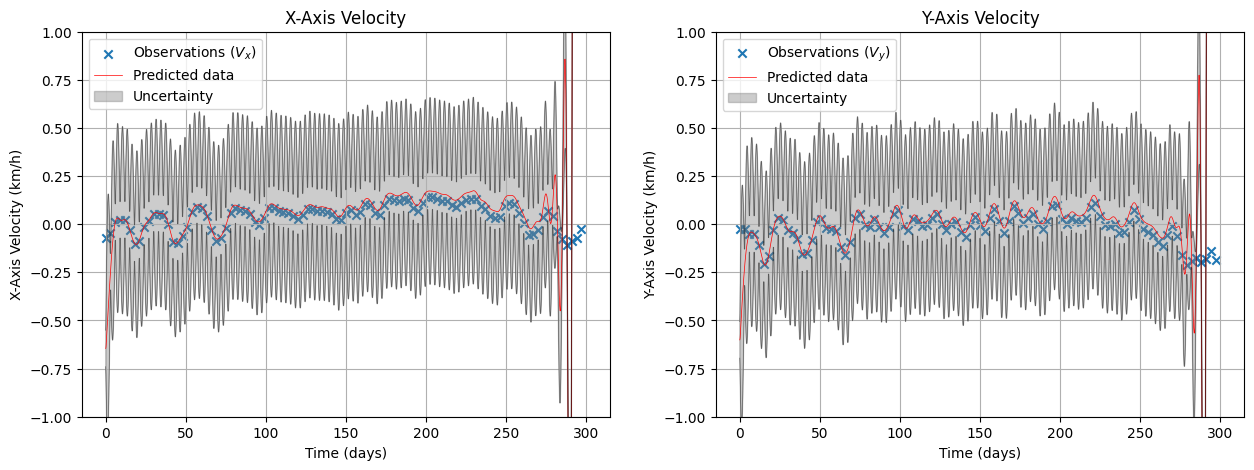

In [13]:
# Select the velocity data for the location selected in 4.a
x = 200
y = 400
Vx_loc = Vt[:, y, x, 0]
Vy_loc = Vt[:, y, x, 1]

# Currently we have measurements for every 3 days. We previously assumed that
# ocean currents remain constant for about 3 hours, therefore, we can predict
# the velocity at smaller time intervals by having 24 measurements in between
# each of the original measurements (i.e. 24 * 3 = 72 hours = 3 days).
X_pred = np.arange(0, Vx_loc.shape[0], 1/24)

# Get the full range of values for X
# (For the Philippines dataset, this is just the X axis of the data, or
# a range from 0 to the number of timesteps)
X = np.arange(Vx_loc.shape[0])

# ================= PREDICTIONS ================ #

# Calculate the conditional mean and variance of the X component
conditional_mean_x, conditional_variance_x, _ = predict_conditional_mean_and_var(
    x1=X_pred,
    x2=X,
    y2=Vx_loc,
    kernel_args=(optimal_l_x, optimal_std_x)
)

# Calculate the conditional mean and variance of the Y component
conditional_mean_y, conditional_variance_y, _ = predict_conditional_mean_and_var(
    x1=X_pred,
    x2=X,
    y2=Vy_loc,
    kernel_args=(optimal_l_y, optimal_std_y)
)

# Extract the variance along the diagonal
var_x = np.sqrt(np.diagonal(conditional_variance_x))
var_y = np.sqrt(np.diagonal(conditional_variance_y))

# ============== PLOT X COMPONENT ============== #

# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Convert the "X" values to days by multiplying by 3
t_days = X * 3

# Convert the "X_pred" values to days by multiplying by 3
t_pred_days = X_pred * 3

# Plot the results
ax1.scatter(
    t_days,
    Vx_loc,
    label='Observations ($V_x$)',
    marker='x',
)
ax1.plot(
    t_pred_days,
    conditional_mean_x,
    label='Predicted data',
    color='red',
    linewidth=0.5
)
ax1.plot(
    t_pred_days,
    conditional_mean_x + 3*var_x,
    color="black",
    linewidth=0.5,
    alpha=0.5
)
ax1.plot(
    t_pred_days,
    conditional_mean_x - 3*var_x,
    color="black",
    linewidth=0.5,
    alpha=0.5
)
ax1.fill_between(
    t_pred_days,
    conditional_mean_x + 3*var_x,
    conditional_mean_x - 3*var_x,
    label="Uncertainty",
    color="gray",
    alpha=0.4
)

ax1.legend()
ax1.grid()
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('X-Axis Velocity (km/h)')
ax1.set_title('X-Axis Velocity')

# ============== PLOT Y COMPONENT ============== #

ax2.scatter(
    t_days,
    Vy_loc,
    label='Observations ($V_y$)',
    marker='x',
)
ax2.plot(
    t_pred_days,
    conditional_mean_y,
    label='Predicted data',
    color='red',
    linewidth=0.5
)
ax2.plot(
    t_pred_days,
    conditional_mean_y + 3*var_y,
    color="black",
    linewidth=0.5,
    alpha=0.5
)
ax2.plot(
    t_pred_days,
    conditional_mean_y - 3*var_y,
    color="black",
    linewidth=0.5,
    alpha=0.5
)
ax2.fill_between(
    t_pred_days,
    conditional_mean_y + 3*var_y,
    conditional_mean_y - 3*var_y,
    label="Uncertainty",
    color="gray",
    alpha=0.4
)

ax2.legend()
ax2.grid()
ax2.set_xlabel('Time (days)')
ax2.set_ylabel('Y-Axis Velocity (km/h)')
ax2.set_title('Y-Axis Velocity')

# Set max value of Y to 2
ax1.set_ylim([-1, 1])
ax2.set_ylim([-1, 1])

plt.show()
